# Sentiment Analysis of Amazon's customer reviews

In [282]:
# General packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# NLP packages
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

We will be working with a .csv file that contains information about tens of thousands of customers writing reviews on Amazon products every day. Each review contains textual feedback along with a 1-to-5 star rating system (1 being least satisfied and 5 being most satisfied).

1. **Id (numerical):** start and end date of the attack in *timestamp* format.
2. **ProductId (categorical):** ID of the referenced product by the customer.
3. **UserId (categorical):** registered user ID.
4. **ProfileName (text):** registered user profile name.
5. **HelpfulnessNumerator (numerical):** number of users who found the review helpful.
6. **HelpfulnessDenominator (numerical):** Number of users who voted whether the review was helpful or not.
7. **Score (ordinal):** rating between 1 and 5.
8. **Time (numerical):** timestamp of the review.
9. **Summary (text):** brief summary of the review.
10. **Text (text):** text of the review.

**Dataset Link:** https://www.kaggle.com/code/chirag9073/amazon-fine-food-reviews-sentiment-analysis/input

In [283]:
df = pd.read_csv('Customer_Reviews.csv')
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


***Let's look at the distribution of number of words per review. We will do this by applying a *lambda* function that splits each complete review by spaces, which will give us the borad words:***

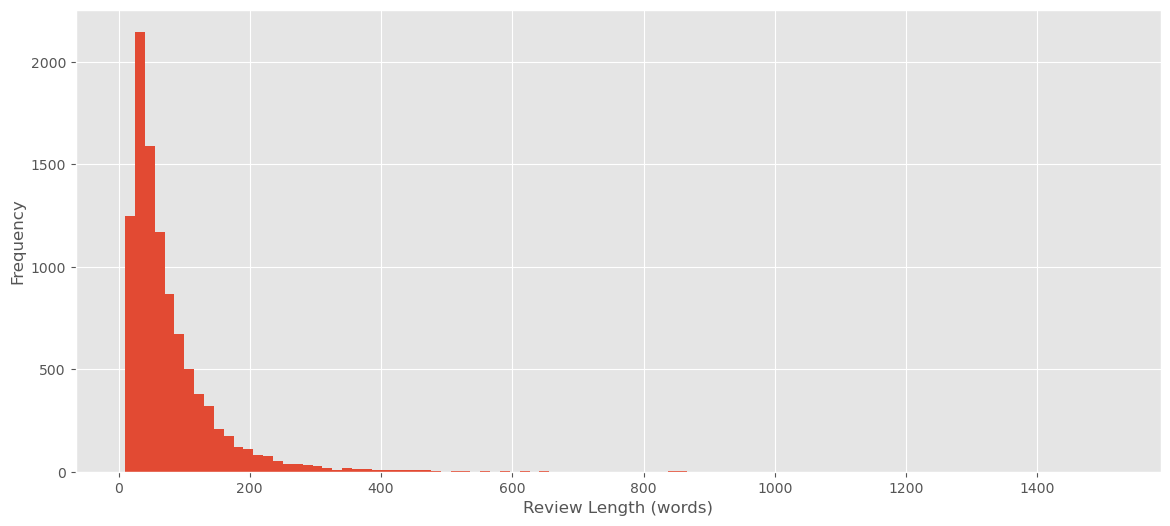

In [284]:
## Getting the number of words by splitting them by a space
words_per_review = df.Text.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

In [285]:
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 77.9028
Skewness: 4.612459483340116


We can see that the number of words per user review is highly positive skewed with mean of 77, which means that on average, user reviews have 77 words.

Let's also look at the distribution of ratings:

In [286]:
percent_val = 100 * df['Score'].value_counts()/len(df)
percent_val

Score
5    61.83
4    14.33
1     9.32
3     8.62
2     5.90
Name: count, dtype: float64

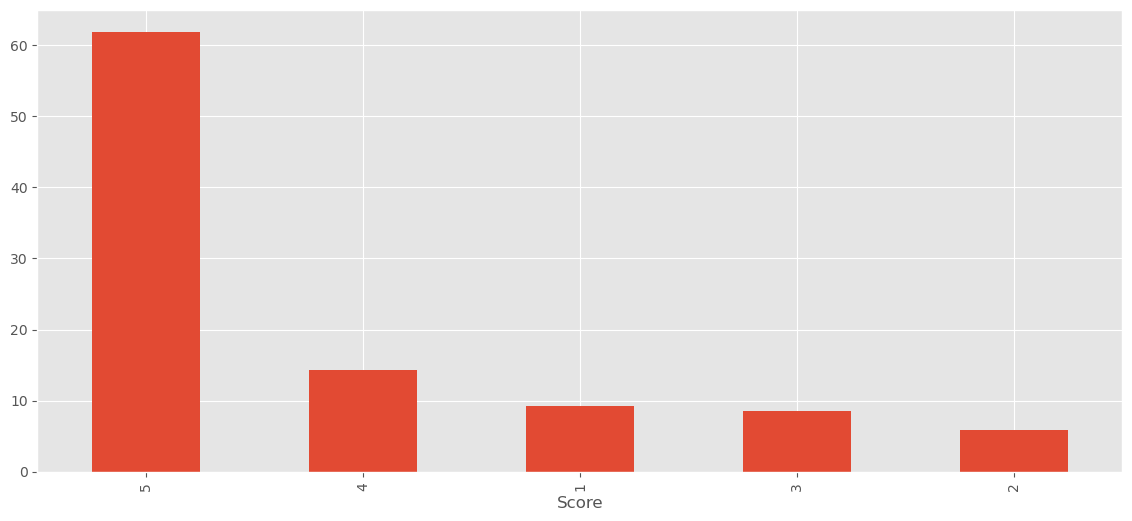

In [287]:
percent_val.plot.bar()
plt.show()

The distribution is quite skewed, with a giant number of 5s and very few 3s, 2s, and 1s.

### Text visualization using word clouds (*word clouds* )

As visualization is crucial for numerical data, it is also important for text data. However, the text does not lend itself to histogram charts or scatterplots, as numerical data does. In such cases, the **word clouds** are a common and very useful tool to appreciate the text distribution.

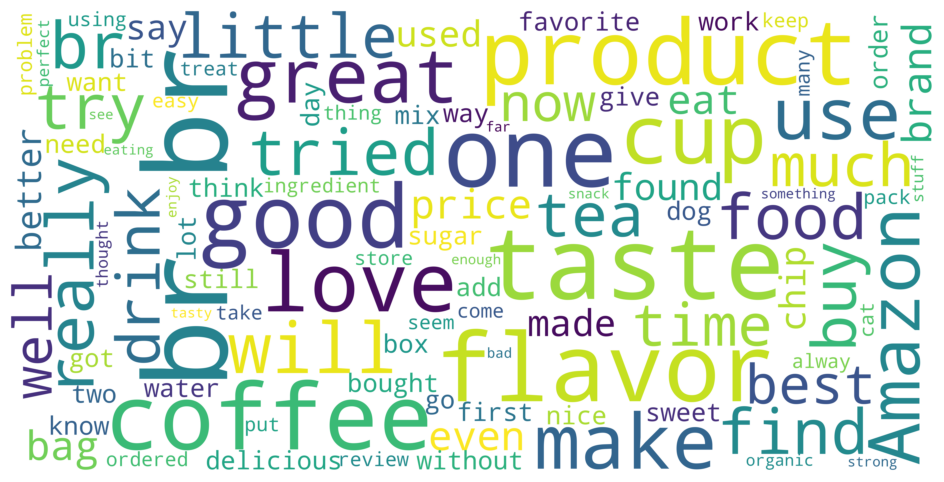

In [288]:
word_cloud_text = ''.join(df['Text'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

The word cloud indicates that many of the reviews talk about food-related things - coffee, flavor, food, taste, drink. We also see some positive words like good, love, best, as well as not desired ones such as br (line break), many (determiner) and something (adverb).

### Standardizing the ratings for sentiment analysis (5 mts)

For the purposes of sentiment analysis, we will convert all of the ratings into binary values using the follow rule: 
- Ratings of more than 3 is considered as positive reviews
- Ratings of less than 3 is considered as negative reviews
- Ratings of 3 will assigned as neutral reviews.

In [289]:
# Mapping the ratings
df['Sentiment_rating'] = np.where(df.Score > 3, 'Positive', np.where(df.Score < 3, 'Negative', 'Neutral'))

# Printing the counts of each class
df['Sentiment_rating'].value_counts()

Sentiment_rating
Positive    7616
Negative    1522
Neutral      862
Name: count, dtype: int64

**Let's see the words people are using in positive and negative reviews of summary**

In [321]:
corpus_pos = ' '.join(df[df['Sentiment_rating'] == 'Positive']['Text'])
corpus_neg=' '.join(df[df['Sentiment_rating'] == 'Negative']['Text'])
corpus_neutral=' '.join(df[df['Sentiment_rating'] == 'Neutral']['Text'])

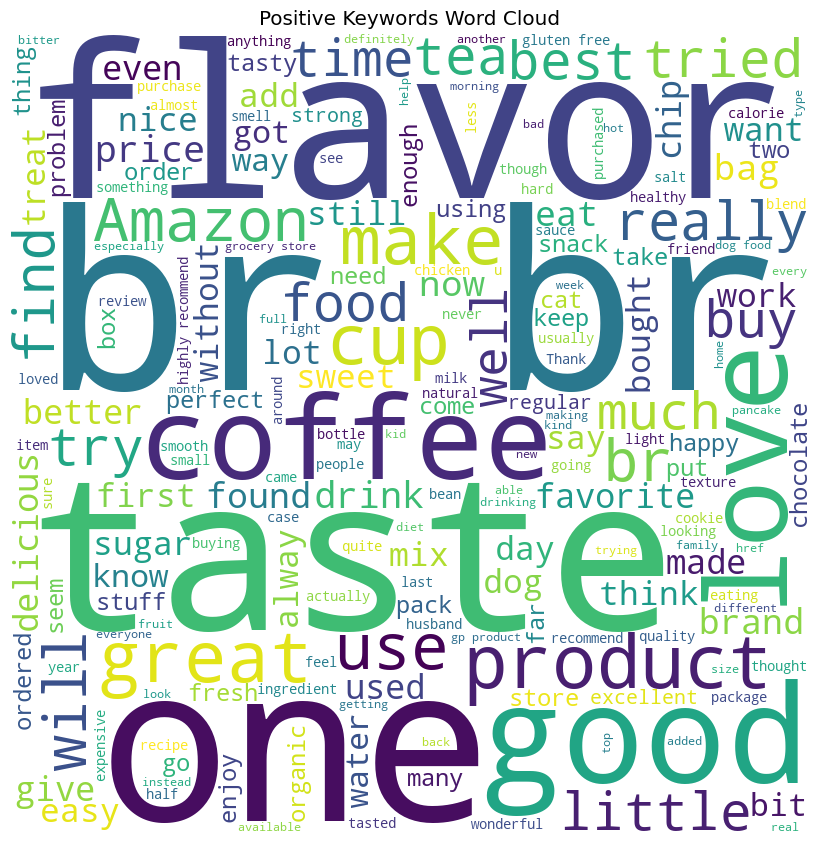

In [322]:
# Create word clouds
positive_wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(corpus_pos)
negative_wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(corpus_neg)
neutral_wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(corpus_neutral)

# Plot word clouds
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(positive_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Positive Keywords Word Cloud')
plt.show()


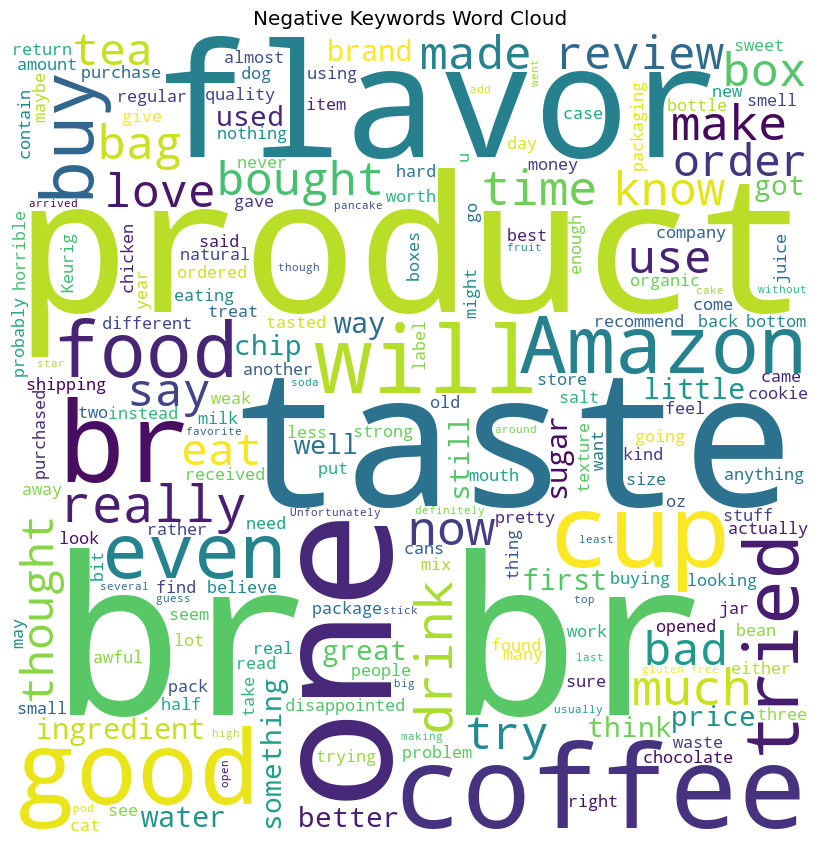

In [323]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(negative_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Negative Keywords Word Cloud')
plt.show()

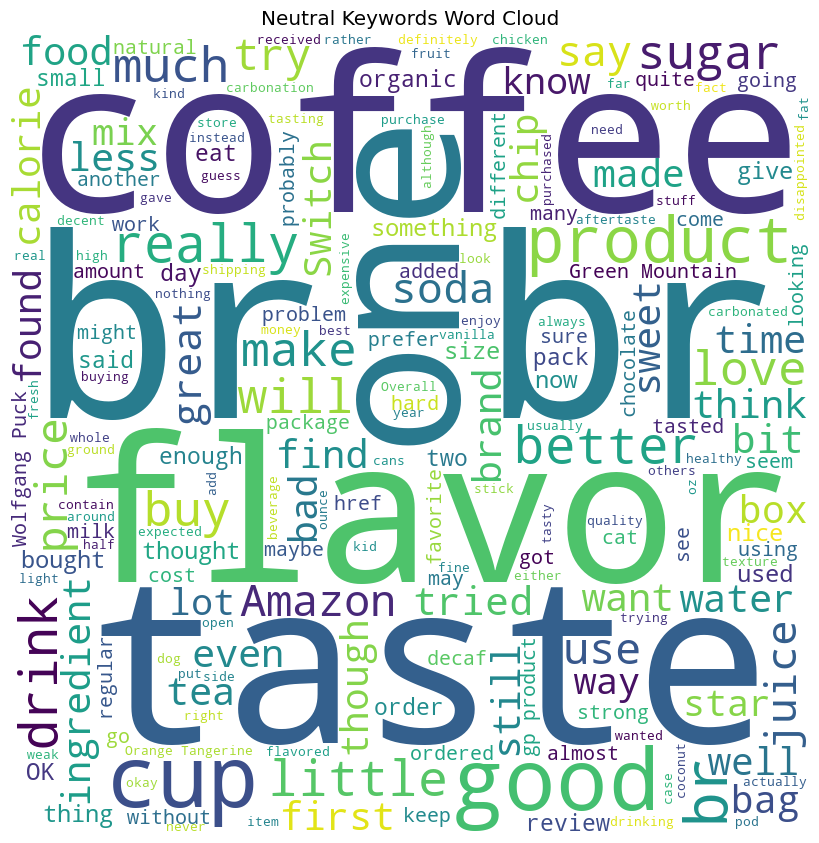

In [324]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(neutral_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Neutral Keywords Word Cloud')
plt.show()

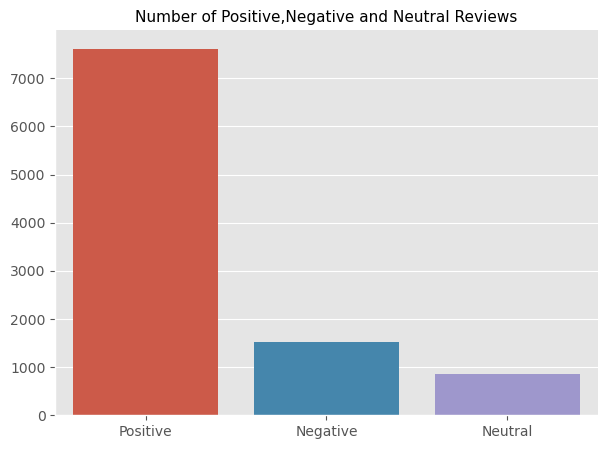

In [294]:
import matplotlib.pyplot as plt
num_positive =df.Sentiment_rating.value_counts()[0]
num_negative = df.Sentiment_rating.value_counts()[1]
num_neutral = df.Sentiment_rating.value_counts()[2]

types = ['Positive', 'Negative','Neutral']
counts = [num_positive, num_negative,num_neutral]

plt.figure(figsize=(7, 5))
sns.barplot(x = types, y = counts)
plt.title("Number of Positive,Negative and Neutral Reviews", fontsize=11)
sns.despine();


**There is a class imbalance that we are going to handle by defining robust metrics.**

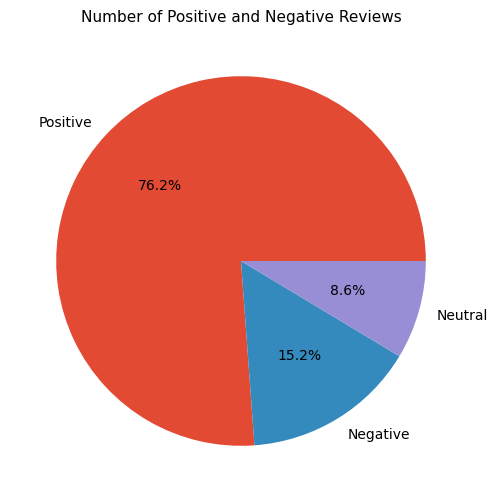

In [295]:
#it show how target feature(classes) it classified.
plt.pie(df.Sentiment_rating.value_counts(), labels=['Positive', 'Negative','Neutral'],autopct='%1.1f%%')
plt.title("Number of Positive and Negative Reviews", fontsize=11)
plt.show()

**Trend Analysis:**

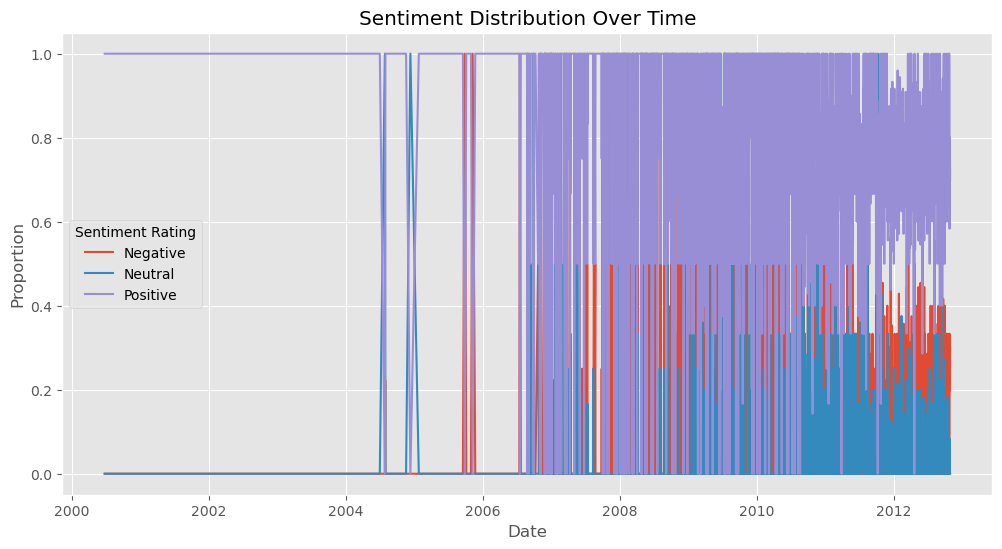

In [296]:
# Convert the 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'], unit='s')

# Group the data by time periods (e.g., days)
df['Date'] = df['Time'].dt.date
sentiment_distribution = df.groupby('Date')['Sentiment_rating'].value_counts(normalize=True).unstack().fillna(0)

# Plot the sentiment distribution over time
sentiment_distribution.plot(kind='line', figsize=(12, 6))
plt.title('Sentiment Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.legend(title='Sentiment Rating')
plt.show()


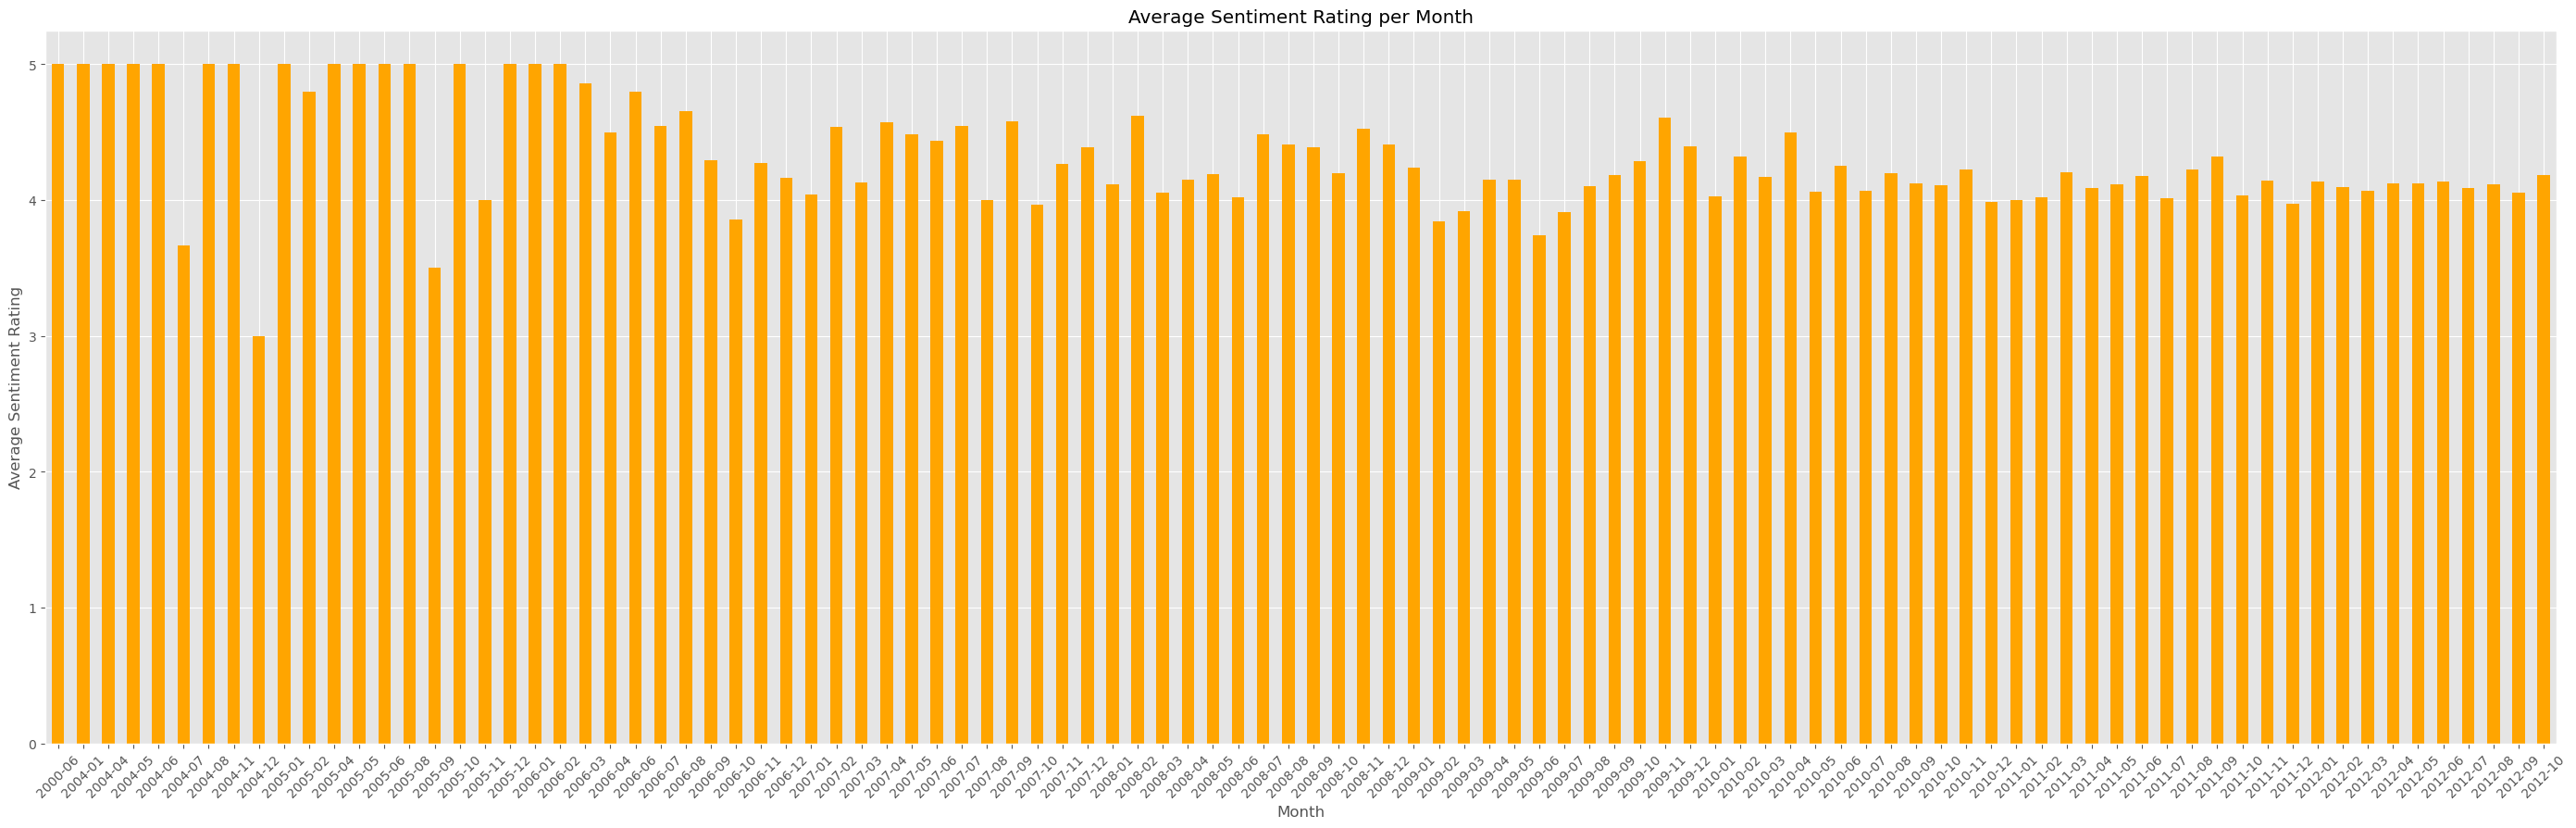

In [305]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract month and year from date
df['Month'] = df['Date'].dt.to_period('M')

# Calculate average sentiment rating for each month
average_sentiment = df.groupby('Month')['Score'].mean()

# Plot
plt.figure(figsize=(35, 10))
average_sentiment.plot(kind='bar', color='orange')
plt.title('Average Sentiment Rating per Month',)
plt.xlabel('Month')
plt.ylabel('Average Sentiment Rating')
plt.xticks(rotation=45)
plt.show()

<Figure size 2000x700 with 0 Axes>

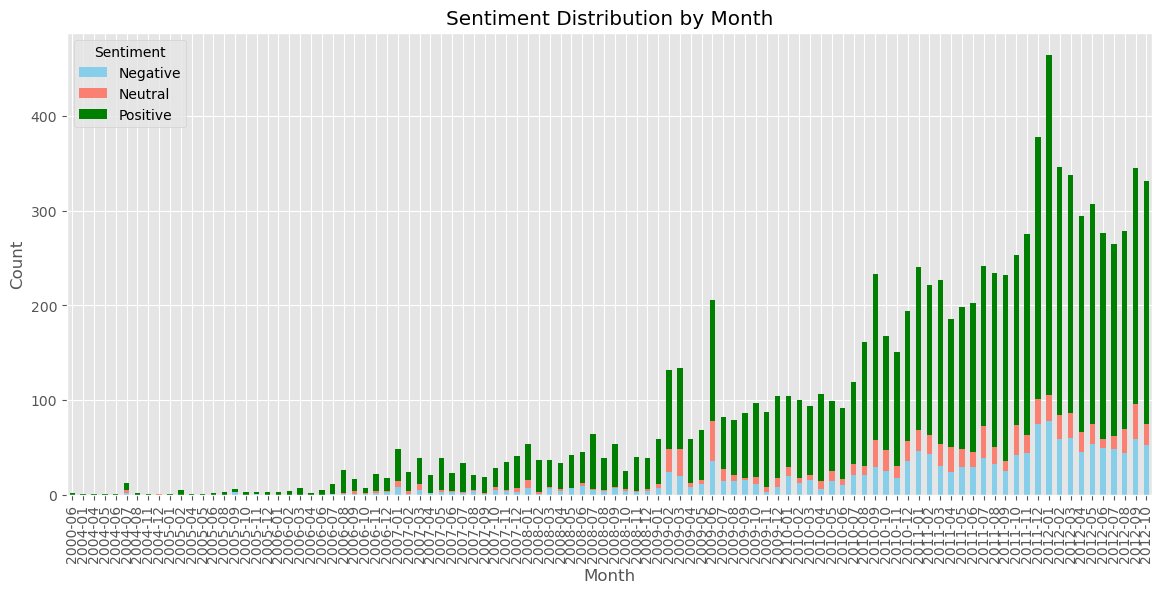

In [329]:
# Count sentiment ratings by month
trend_data = df.groupby(['Month', 'Sentiment_rating']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(20, 7))
trend_data.plot(kind='bar', stacked=True, color=['skyblue', 'salmon','green'])
plt.title('Sentiment Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Count')
# plt.xticks(rotation=30)
plt.legend(title='Sentiment')
plt.show()

## Pre-processing

Text preprocessing and normalization is crucial before building a proper NLP model. 
Some of the important steps are:

1. Converting words to lower/upper case
2. Removing special characters, emoji's and other characters
3. Removing stopwords and high/low-frequency words
4. Stemming/lemmatization

**Text Preprocessing**

In [18]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords

In [19]:
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment_rating
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive


In [157]:
import re
import string
import nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
stop_words = set(stopwords.words('english'))

def remove_html_tags(text):
    # Remove HTML tags using BeautifulSoup
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def remove_special_characters(text):
    # Remove special characters using regex
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def remove_emojis(text):
    # Remove emojis using regex
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def preprocess_text(text):
    # Remove HTML tags
    text = remove_html_tags(text)

    # Remove special characters
    text = remove_special_characters(text)

    # Remove emojis
    text = remove_emojis(text)

    # Convert to lowercase
    text = text.lower()
    
    text = re.sub(r'\d+', '', text)  # removes digits
    
    #remove punctuations
    
    words = text.translate(str.maketrans("", "", string.punctuation))
    
    
    # Tokenization
    words = word_tokenize(text)
    
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # lemmatization for finding root words
    wordnet = WordNetLemmatizer()
    words = [wordnet.lemmatize(word) for word in words]

    # Join the words back into a sentence
    preprocessed_text = ' '.join(words)

    return preprocessed_text

In [142]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['Sentiment_rating']=le.fit_transform(df['Sentiment_rating'])

In [143]:
df.Sentiment_rating.value_counts()

Sentiment_rating
2    7616
0    1522
1     862
Name: count, dtype: int64

In [24]:
# Apply text cleaning to the 'text' column
df['Text'] = df['Text'].apply(preprocess_text)

In [25]:
df[['Text','Sentiment_rating']]

,Text,Sentiment_rating
0,bought several vitality canned dog food produc...,2
1,product arrived labeled jumbo salted peanutsth...,0
2,confection around century light pillowy citrus...,2
3,looking secret ingredient robitussin believe f...,0
4,great taffy great price wide assortment yummy ...,2
...,...,...
9995,switched advance similac organic product think...,0
9996,like bad review say organic formula constipate...,2
9997,wanted solely breastfeed unable keep supplemen...,2
9998,love fact get delieved house delievy chargeit ...,2


In [194]:
#Split input and target variable for model building
X=df['Text']
y=df['Sentiment_rating']

**Feature Embedding using ROBERTa Model**

***RoBERTa (Robustly optimized BERT approach) is a variant of the BERT (Bidirectional Encoder Representations from Transformers) model, which is based on the Transformer architecture. Like BERT, RoBERTa is a pre-trained model that can be fine-tuned for various natural language processing (NLP) tasks, such as text classification, question answering, and text generation.***

***Feature extraction using the RoBERTa model involves using the pre-trained RoBERTa model to convert input text into a set of contextualized embeddings, which can then be used as features for downstream tasks.***

In [195]:
from transformers import RobertaTokenizer, RobertaModel
import torch

# Load pre-trained BERT model and tokenizer
roberta_model = RobertaModel.from_pretrained('roberta-base')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [196]:
def get_bert_vectors(text):
    tokens = roberta_tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = roberta_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [197]:
# Apply the function to get BERT vectors
df['roberta_vectors'] = df['Text'].apply(get_bert_vectors)

In [198]:
len(df['roberta_vectors'][0])

768

In [199]:
#Here Roberta embedding model generates 768 embedding for each sentence
df['roberta_vectors'] = df['roberta_vectors'].apply(lambda x: x[:768])

In [201]:
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment_rating,roberta_vectors
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2,"[-0.007995754, 0.25393537, 0.038997397, -0.134..."
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,"[-0.054219645, 0.08942584, 0.050335716, -0.082..."
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2,"[0.038801756, 0.12356687, 0.019217841, -0.0677..."
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,"[0.029536637, 0.11919202, 0.031722844, 0.02758..."
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2,"[-0.03225325, 0.13816184, -0.0030402467, -0.03..."


In [202]:
# Create separate columns for each feature
df_features = pd.DataFrame(df['roberta_vectors'].to_list(), columns=[f'feature_{i+1}' for i in range(768)])

In [203]:
df_features.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
0,-0.007996,0.253935,0.038997,-0.134713,0.121958,0.160415,0.046121,0.050578,-0.014332,0.038233,...,-0.051296,-0.028562,0.023549,0.020302,0.086594,-0.008014,0.078046,-0.000903,0.009863,-0.055341
1,-0.054220,0.089426,0.050336,-0.082320,0.181759,0.223779,0.016698,0.107644,-0.025418,-0.060849,...,0.029948,-0.066671,0.037171,-0.000870,0.054000,0.005669,0.068636,-0.146316,0.026104,0.043646
2,0.038802,0.123567,0.019218,-0.067786,0.285822,0.140316,0.005560,0.020638,-0.066371,0.086617,...,-0.089271,-0.069915,-0.042195,-0.006139,0.107753,0.119635,-0.053257,0.027586,0.044009,0.041874
3,0.029537,0.119192,0.031723,0.027581,0.037757,0.338464,0.039688,0.024410,-0.071395,0.063776,...,-0.084583,-0.081600,-0.045039,0.052895,0.043437,0.018712,0.116332,0.084764,0.048627,-0.031822
4,-0.032253,0.138162,-0.003040,-0.033106,0.057572,0.328018,-0.013710,-0.090103,0.017127,0.017596,...,-0.093466,-0.059942,-0.054835,0.043154,0.078892,0.096537,0.025277,-0.037899,0.030053,0.037352


In [204]:
# Concatenate the new columns with the original DataFrame
df = pd.concat([df, df_features], axis=1)

In [205]:
# dropping the unwanted columns
df = df.drop(['ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time','Summary','Text', 'roberta_vectors'], axis=1)

In [206]:
df.head()

,Sentiment_rating,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
0,2,-0.007996,0.253935,0.038997,-0.134713,0.121958,0.160415,0.046121,0.050578,-0.014332,...,-0.051296,-0.028562,0.023549,0.020302,0.086594,-0.008014,0.078046,-0.000903,0.009863,-0.055341
1,0,-0.054220,0.089426,0.050336,-0.082320,0.181759,0.223779,0.016698,0.107644,-0.025418,...,0.029948,-0.066671,0.037171,-0.000870,0.054000,0.005669,0.068636,-0.146316,0.026104,0.043646
2,2,0.038802,0.123567,0.019218,-0.067786,0.285822,0.140316,0.005560,0.020638,-0.066371,...,-0.089271,-0.069915,-0.042195,-0.006139,0.107753,0.119635,-0.053257,0.027586,0.044009,0.041874
3,0,0.029537,0.119192,0.031723,0.027581,0.037757,0.338464,0.039688,0.024410,-0.071395,...,-0.084583,-0.081600,-0.045039,0.052895,0.043437,0.018712,0.116332,0.084764,0.048627,-0.031822
4,2,-0.032253,0.138162,-0.003040,-0.033106,0.057572,0.328018,-0.013710,-0.090103,0.017127,...,-0.093466,-0.059942,-0.054835,0.043154,0.078892,0.096537,0.025277,-0.037899,0.030053,0.037352


In [207]:
df.to_csv('features_with_labels.csv', index = False)

In [1]:
import pandas as pd
df=pd.read_csv('features_with_labels.csv')

In [2]:
X = df.drop(['Sentiment_rating'], axis=1)
y = df['Sentiment_rating']

In [3]:
#RandomOverSampler-Balancing data
from imblearn.over_sampling import RandomOverSampler
rs=RandomOverSampler()
X,y=rs.fit_resample(X,y)

In [4]:
y.value_counts()

Sentiment_rating
2    7616
0    7616
1    7616
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101)

In [6]:
from sklearn.ensemble import RandomForestClassifier
rs=RandomForestClassifier()
rs.fit(x_train,y_train)

RandomForestClassifier()

In [249]:
import pickle
# Save the model to a file
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rs, file)

**Performance Metrics of Random Forest Model**

In [213]:
# Make predictions on the test set
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,classification_report,f1_score
from sklearn import metrics
import numpy as np
import seaborn as sns
y_pred_train = rs.predict(x_train)
# Evaluate the model
train_acc = accuracy_score(y_train, y_pred_train)
y_pred_test = rs.predict(x_test)
# Evaluate the model
test_acc = accuracy_score(y_test, y_pred_test)
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Train Accuracy: 1.0
Test Accuracy: 0.987308533916849


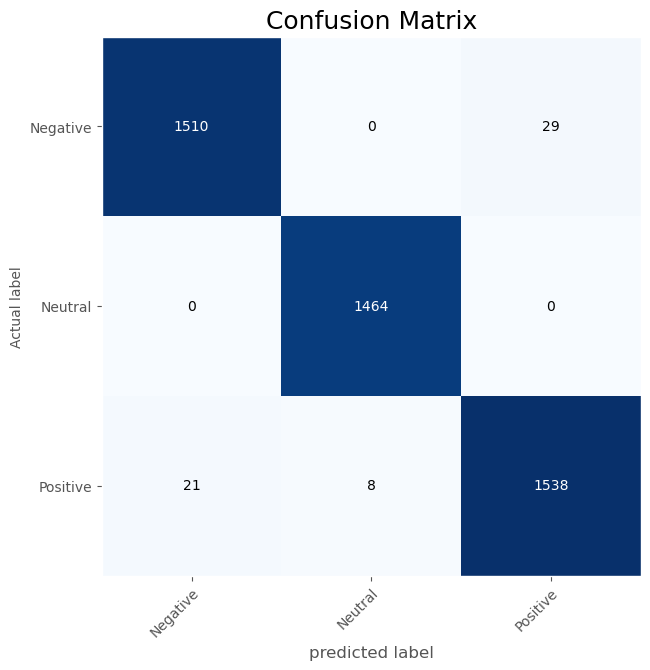

In [214]:
y_inverse=le.inverse_transform(y)
conf_matrix = confusion_matrix(y_test,y_pred_test)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(10, 7), cmap=plt.cm.Blues,class_names=list(np.unique(y_inverse)))
plt.ylabel('Actual label', fontsize=10)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [215]:
print('Classification Report')
print(classification_report(y_test,y_pred_test))
# accuracy: (tp + tn) / (p + n)
RF_accuracy = accuracy_score(y_test,y_pred_test)
print('Accuracy: %f' % RF_accuracy)
# precision: tp / (tp + fp)
RF_precision = precision_score(y_test,y_pred_test,average='weighted')
print('Precision: %f' % RF_precision)
# recall: tp / (tp + fn)
RF_recall = recall_score(y_test,y_pred_test,average='weighted')
print('Recall: %f' % RF_recall)
# FMeasure = (2 * Precision * Recall) / (Precision + Recall)
RF_f1_score = f1_score(y_test,y_pred_test,average='weighted')
print('F1-Score: %f' % RF_f1_score)

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1539
           1       0.99      1.00      1.00      1464
           2       0.98      0.98      0.98      1567

    accuracy                           0.99      4570
   macro avg       0.99      0.99      0.99      4570
weighted avg       0.99      0.99      0.99      4570

Accuracy: 0.987309
Precision: 0.987294
Recall: 0.987309
F1-Score: 0.987297


**To Plot ROC curve of Random forest Model**

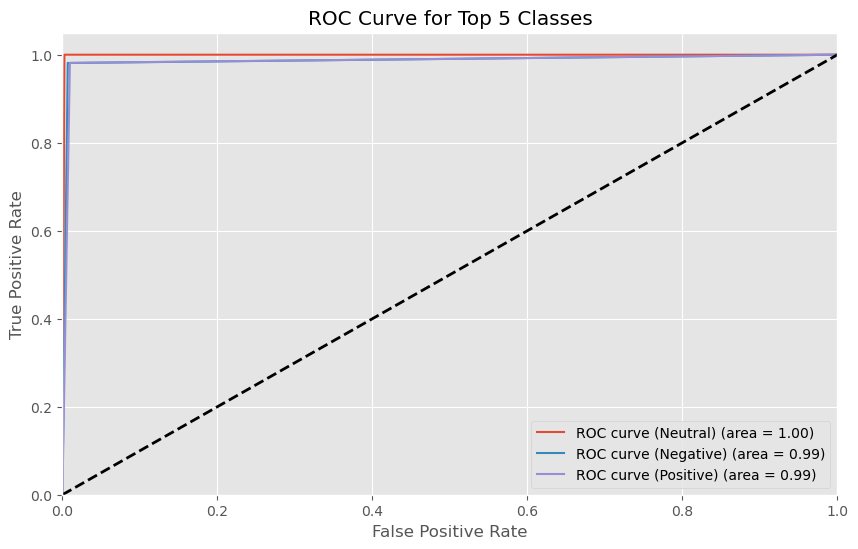

In [216]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
n_classes=3
# Binarize the labels
y_test_bin = label_binarize(y_test, classes=range(n_classes))
y_pred_bin = label_binarize(y_pred_test, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Select top 5 classes based on AUC values
top_classes = sorted(range(n_classes), key=lambda x: roc_auc[x], reverse=True)[:5]

# Plot ROC curve for the top 5 classes
plt.figure(figsize=(10, 6))
for i in top_classes:
    j=le.inverse_transform([i])
    plt.plot(fpr[i], tpr[i], label=f'ROC curve ({j[0]}) (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Top 5 Classes')
plt.legend(loc="lower right")
plt.show()


**To build ANN model for Sentimental Analysis**

In [7]:
import keras
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Flatten, LSTM, BatchNormalization, MaxPooling1D
model = Sequential()
model.add(Dense(1024, input_dim = 768, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              787456    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)             

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2,shuffle=True,callbacks=[early_stopping])

Epoch 1/10


229/229 [==============================] - 6s 19ms/step - loss: 0.7219 - accuracy: 0.6683 - val_loss: 0.5963 - val_accuracy: 0.7541
Epoch 2/10
229/229 [==============================] - 4s 17ms/step - loss: 0.5397 - accuracy: 0.7842 - val_loss: 0.4977 - val_accuracy: 0.7987
Epoch 3/10
229/229 [==============================] - 4s 18ms/step - loss: 0.4424 - accuracy: 0.8295 - val_loss: 0.4941 - val_accuracy: 0.8042
Epoch 4/10
229/229 [==============================] - 4s 17ms/step - loss: 0.3473 - accuracy: 0.8742 - val_loss: 0.3734 - val_accuracy: 0.8523
Epoch 5/10
229/229 [==============================] - 4s 18ms/step - loss: 0.2719 - accuracy: 0.9034 - val_loss: 0.2817 - val_accuracy: 0.8999
Epoch 6/10
229/229 [==============================] - 4s 17ms/step - loss: 0.2174 - accuracy: 0.9259 - val_loss: 0.2436 - val_accuracy: 0.9182
Epoch 7/10
229/229 [==============================] - 4s 18ms/step - loss: 0.1774 - accuracy: 0.9411 - val_loss: 0.2559 - val_accuracy: 0.90

In [248]:
model.save('ANN-Model.keras')

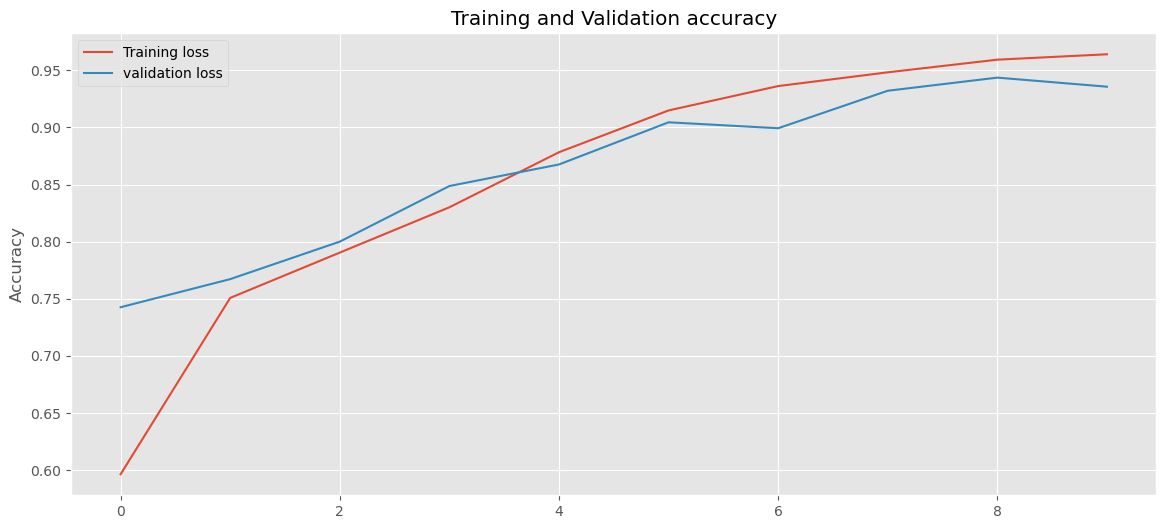

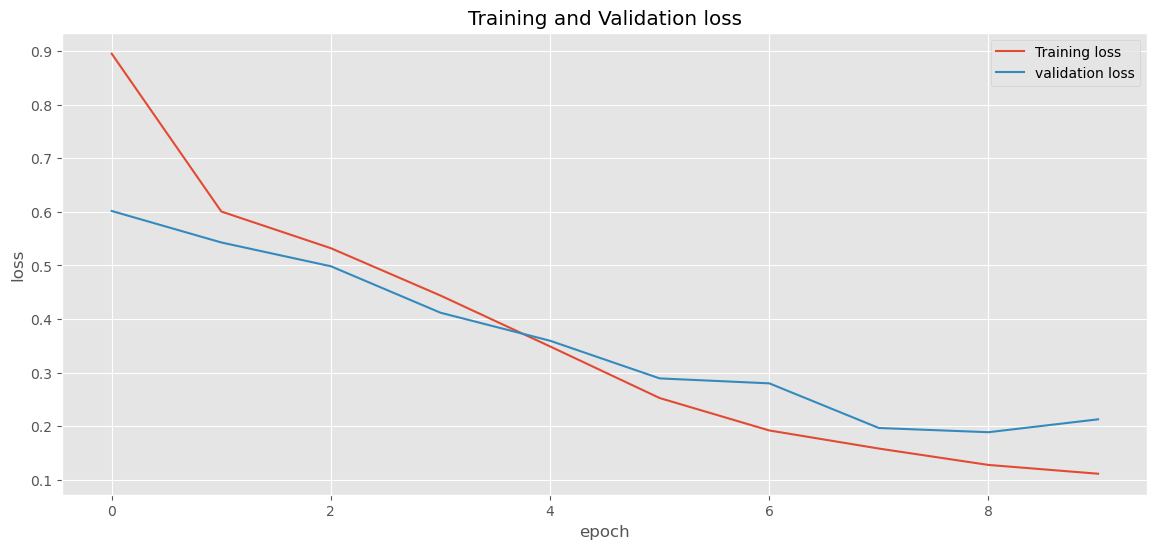

In [221]:
# Plot the changes in accuracy and loss over epochs
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.plot(history.history['accuracy'])
plt.plot(history.history["val_accuracy"])
plt.title("Training and Validation accuracy")
plt.ylabel('Accuracy', fontsize="large")
plt.legend(['Training loss','validation loss'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation loss")
plt.ylabel("loss", fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(['Training loss','validation loss'])
plt.show()

In [222]:
# Make predictions on the test set
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,classification_report,f1_score
from sklearn import metrics
import numpy as np
import seaborn as sns
y_pred_train = model.predict(x_train)
y_pred_train = np.argmax(y_pred_train, axis=-1)
# Evaluate the model
train_acc = accuracy_score(y_train, y_pred_train)
y_pred_test = model.predict(x_test,batch_size=64)
y_pred_test = np.argmax(y_pred_test, axis=-1)
# Evaluate the model
test_acc = accuracy_score(y_test, y_pred_test)
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

72/72 [==============================] - 0s 3ms/step
Train Accuracy: 0.9580916949338002
Test Accuracy: 0.9330415754923413


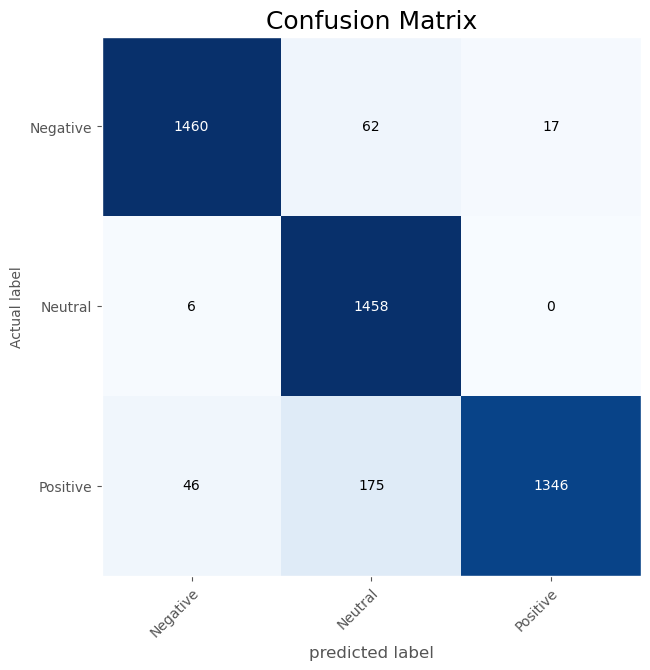

In [223]:
y_inverse=le.inverse_transform(y)
conf_matrix = confusion_matrix(y_test,y_pred_test)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(10, 7), cmap=plt.cm.Blues,class_names=list(np.unique(y_inverse)))
plt.ylabel('Actual label', fontsize=10)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [224]:
print('Classification Report')
print(classification_report(y_test,y_pred_test))
# accuracy: (tp + tn) / (p + n)
Ann_accuracy = accuracy_score(y_test,y_pred_test)
print('Accuracy: %f' % Ann_accuracy)
# precision: tp / (tp + fp)
Ann_precision = precision_score(y_test,y_pred_test,average='weighted')
print('Precision: %f' % Ann_precision)
# recall: tp / (tp + fn)
Ann_recall = recall_score(y_test,y_pred_test,average='weighted')
print('Recall: %f' % Ann_recall)
# Sensitivity/TPR=TP/TP+FN-It tells us what proportion of the positive class got correctly classified.
Ann_sensitivity=conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])
print('Sensitivity: %f' % Ann_sensitivity)
# specificity: TN / float(TN+FP)
Ann_specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
print('Specificity: %f' % Ann_specificity)
# f1: 2 tp / (2 tp + fp + fn)
# FMeasure = (2 * Precision * Recall) / (Precision + Recall)
Ann_f1_score = f1_score(y_test,y_pred_test,average='weighted')
print('F1-Score: %f' % Ann_f1_score)

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1539
           1       0.86      1.00      0.92      1464
           2       0.99      0.86      0.92      1567

    accuracy                           0.93      4570
   macro avg       0.94      0.93      0.93      4570
weighted avg       0.94      0.93      0.93      4570

Accuracy: 0.933042
Precision: 0.939349
Recall: 0.933042
Sensitivity: 0.995902
Specificity: 0.959264
F1-Score: 0.933046


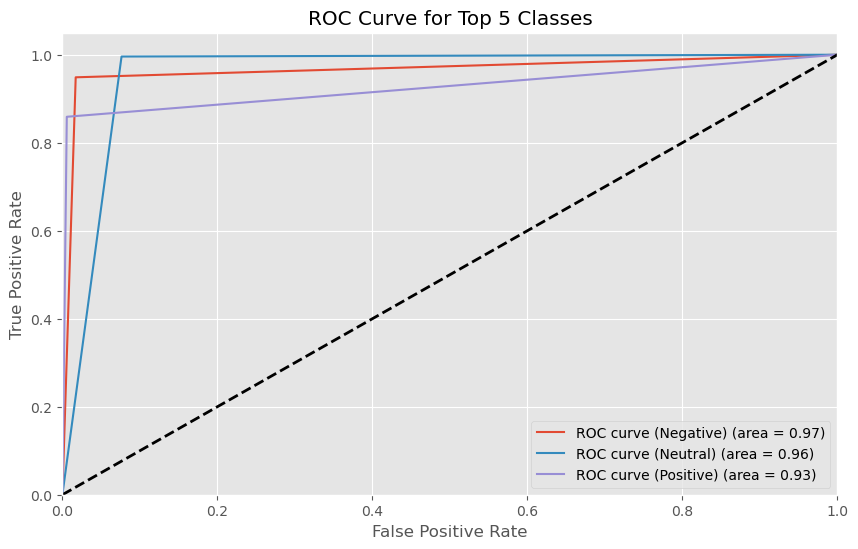

In [225]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
n_classes=3
# Binarize the labels
y_test_bin = label_binarize(y_test, classes=range(n_classes))
y_pred_bin = label_binarize(y_pred_test, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Select top 5 classes based on AUC values
top_classes = sorted(range(n_classes), key=lambda x: roc_auc[x], reverse=True)[:5]

# Plot ROC curve for the top 5 classes
plt.figure(figsize=(10, 6))
for i in top_classes:
    j=le.inverse_transform([i])
    plt.plot(fpr[i], tpr[i], label=f'ROC curve ({j[0]}) (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Top 5 Classes')
plt.legend(loc="lower right")
plt.show()


In [226]:
x_train.shape

(18278, 768)

In [240]:
# Function to preprocess text and get RoBERTa embeddings
def get_bert_vectors(text):
    tokens = roberta_tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = roberta_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Function to predict sentiment of a new text input
def predict_sentiment(text):
    bert_vector = get_bert_vectors(text)
    prediction = model.predict(bert_vector.reshape(1, -1))
    return prediction[0]

# Example new text
new_text = "This is a great product!"
predicted_sentiment = predict_sentiment(new_text)
predicted_sentiment=np.argmax(predicted_sentiment)
predict_sentiment=le.inverse_transform(predicted_sentiment.reshape(1,-1))
print("Predicted sentiment:", predict_sentiment[0])

1/1 [==============================] - 0s 20ms/step
Predicted sentiment: Positive


In [245]:
# Function to preprocess text and get RoBERTa embeddings
def get_bert_vectors(text):
    tokens = roberta_tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = roberta_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Function to predict sentiment of a new text input
def predict_sentiment(text):
    bert_vector = get_bert_vectors(text)
    prediction = model.predict(bert_vector.reshape(1, -1))
    return prediction[0]

# Example new text
new_text = "This is a good product but not cost worthy!"
predicted_sentiment = predict_sentiment(new_text)
predicted_sentiment=np.argmax(predicted_sentiment)
predict_sentiment=le.inverse_transform(predicted_sentiment.reshape(1,-1))
print("Predicted sentiment:", predict_sentiment[0])

1/1 [==============================] - 0s 19ms/step
Predicted sentiment: Neutral
